# LIME Examples

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import transformers
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
#from apex import amp
from lime.lime_text import LimeTextExplainer
from pprint import pprint
import dill

In [7]:
#bias_val = torch.load('allsides/allsides_bias_val.pt')
bias_test = torch.load('allsides/allsides_bias_test.pt')

#text_val = torch.load('allsides/allsides_contents_text_val.pt')
text_test = torch.load('allsides/allsides_contents_text_test.pt')

#mask_val = torch.load('allsides/allsides_contents_mask_val.pt')
mask_test = torch.load('allsides/allsides_contents_mask_test.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'allsides/allsides_bias_test.pt'

In [5]:
#allsides_source_val = np.load('allsides/allsides_source_val.npy', allow_pickle=True).flatten()
allsides_source_test = np.load('allsides/allsides_source_test.npy', allow_pickle=True).flatten()

# sources to be removed:
wrongly_labeled = ['RightWingWatch']
news_aggregators = ['Drudge Report', 'Real Clear Politics', 'Yahoo News', 'RightWingWatch'] 
tabloids = ['New York Daily News', 'Daily Mail', 'New York Post'] 
unwanted_sources = wrongly_labeled + news_aggregators + tabloids
# creating boolean array to mark unwanted sources
#boolean_array_val = np.full((len(allsides_source_val), ), False)
boolean_array_test = np.full((len(allsides_source_test), ), False)

for source in unwanted_sources:
#    boolean_array_val += allsides_source_val==source 
    boolean_array_test += allsides_source_test==source 
# boolean to remove aggregators
#inverted_boolean_array_val = np.invert(boolean_array_val)
inverted_boolean_array_test = np.invert(boolean_array_test)

# bias
#bias_val = bias_val[inverted_boolean_array_val]
bias_test = bias_test[inverted_boolean_array_test]

# text and masks
#text_val = text_val[inverted_boolean_array_val]
text_test = text_test[inverted_boolean_array_test]

#mask_val = mask_val[inverted_boolean_array_val]
mask_test = mask_test[inverted_boolean_array_test]

# sources
#allsides_source_val = allsides_source_val[inverted_boolean_array_val]
allsides_source_test = allsides_source_test[inverted_boolean_array_test]

In [6]:
#val_set = TensorDataset(text_val, mask_val, bias_val)
test_set = TensorDataset(text_test, mask_test, bias_test)

In [5]:
##### Create Model class

class Model(nn.Module):
    def __init__(self, hidden_size, num_labels, droput_prob, bert_model_module, output_attentions=False, pooled_output = True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.output_attentions = output_attentions
        self.pooled_output = pooled_output

        self.bert = bert_model_module
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.tanh = nn.Tanh()

        self.classifier_layer = nn.Linear(hidden_size, num_labels) # The values are initialized from U(−sqrt(k),sqrt(k)), where k=1/in_features

    def forward(self, text, mask):
        # token_type_ids and position_ids are created automaticly 
        bert_out = self.bert(input_ids = text, attention_mask = mask)
        
        if self.pooled_output:
            ### Pooled Output
            # Choosing only CLS token output and apply linear layer + TanH 
            pooled_out = bert_out[1]
            # Applying dropout
            pooled_out = self.dropout(pooled_out)

            out = self.classifier_layer(pooled_out)
        else:
            ### Last Layer average
            # summing up over sequence lenght and devide by unmasked sequence length 
            # resulting in tensor with shape (batch_size,hidden_size)
            last_layer = torch.sum(bert_out[0], dim=1)/torch.sum(mask,dim=1).reshape([len(mask),1])
            last_layer = self.tanh(self.linear(last_layer))
            last_layer = self.dropout(last_layer)
            out = self.classifier_layer(last_layer)
               
        # Saving attention layer outputs if set True
        if self.output_attentions:
            out = out, bert_out[2]
        
        return out

In [6]:
##### Loading Bert 
BertModel = transformers.BertModel
# BertTokenizer = transformers.BertTokenizer
# bert_pretrained_weights = 'bert-base-uncased'

### Device to run model on, either GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model inputs
hidden_size = 768
num_labels = 5 
dropout_prob = 0.1
cost_sensitive = False

### Hyperparameters
batch_size = 16 
learning_rate = 2e-5
### Use of nvidia apex for mixed precession calculations
mixed_precision = True 

In [7]:
##### Initilize and configure Bert
bert_model = BertModel.from_pretrained('bert-base-uncased') 

##### Initilize model (reset in model_training_fct below)
model = Model(hidden_size, num_labels, dropout_prob, bert_model, pooled_output=True).to(device)

### Optimizer, choosing learning rate (reset in model_training_fct below)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
### Applying mixed precision to speed up model training (reset in model_training_fct below)
if mixed_precision:
    model, optimizer = amp.initialize(model, optimizer, opt_level="O1") 
### Loss function
if cost_sensitive:
    loss_fct = CostSensitiveCELoss(num_labels).to(device)
else: 
    loss_fct = nn.CrossEntropyLoss().to(device)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [8]:
### loading weights
checkpoint = torch.load('weights/amp_checkpoint_allsides_aggregators_tabloids_duplicates_removed_rerun_1_epoch3.pt')

model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer'])
#amp.load_state_dict(checkpoint['amp'])


<All keys matched successfully>

## Applying LIME

### Setting up variables

In [7]:
# Loading and initilizing tokenizer
BertTokenizer = transformers.BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
#lime_text = text_test
true_labels = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']
#true_values = bias_test.numpy()
#lime_predict_fct__mask = mask_test
num_plots = len(true_labels)
predicted_labels = true_labels
palette = {'Left': 'blue', 'Lean Left': 'slateblue', 'Center': 'grey', 'Lean Right': 'indianred', 'Right': 'red'}


In [65]:
import matplotlib
matplotlib.colors.to_hex('slateblue', keep_alpha=False)

'#6a5acd'

In [11]:
def prediction_fct(text_input):
    '''
    Takes in list of strings, where each string is a whole article
    
    Returns numpy array containing predicted probabilites of shape (d,k)
    where d is the number of article samples given and k is the number of classes (5)
    '''
    prob_list = []
    for sample in text_input:
        token_list = sample.split(' ')[:-1]
        text = torch.tensor(bert_tokenizer.convert_tokens_to_ids(token_list)).unsqueeze(0)
        
    
        with torch.no_grad():
            mask = lime_predict_fct__mask[index].clone().detach().unsqueeze(0)  
            text, mask = text.to(device), mask.to(device)
            output = model(text, mask)
            sample_probabilities = F.softmax(output,1).cpu().numpy()
            prob_list.append(sample_probabilities)    

    probabilities = np.concatenate(prob_list)
    return probabilities

### Selecting article

In [11]:
# choose article index 
index = 275
# copy tensor
text_tensor = lime_text[index].clone().detach() 
# create string to feed into LIME explain_instance
text_tokens = bert_tokenizer.convert_ids_to_tokens(text_tensor)
text_string = ''.join([token + ' ' for token in text_tokens])
# look at article 
#print('Source: ' + sources_array[index]) 
print(f'True Label: {true_labels[int(true_values[index])]}   Source: {allsides_source_test[index]}')
print('-----------------------------------------------------------------------------') 
pprint(text_string)


True Label: Center   Source: Reuters
-----------------------------------------------------------------------------
('[CLS] washington ( reuters ) - president donald trump ##s nominee , brett ka '
 '##vana ##ugh , looked headed for a lifetime job on the u . s . supreme court '
 'on friday after two crucial senators said that sexual misconduct accusations '
 'against the judge would not prevent them from voting to confirm him . if ka '
 '##vana ##ugh is approved in a final senate vote , likely on saturday , trump '
 'will have achieved a victory in his drive to consolidate conservative '
 'dominance of the nations highest court and move the american judiciary right '
 '##ward . two key senators , republican susan collins and democrat joe man '
 '##chin , both seen as swing votes , said they would support ka ##vana ##ugh '
 ', after weeks of debate about sexual violence and the nominees character and '
 'temperament that gripped the nation . a sharply partisan battle over the '
 'nominati

### Running LIME

In [87]:
# # create explaination object
#explainer = LimeTextExplainer(class_names=true_labels) # ['Left', 'Center', 'Right']
#exp = explainer.explain_instance(text_string, prediction_fct, num_features=10, labels=[0,1,2,3,4], num_samples=10000) # labels=[0,1,2,3,4], top_labels=5

#predected_probs = prediction_fct([text_string])
#print(f'Predicted class: {predicted_labels[np.argmax(predected_probs)]} ,')
#print(f'True class: {true_labels[int(true_values[index])]}') 
#print(f'Probabilites in %: {predected_probs[0,0]*100:.4} {predicted_labels[0]}, {predected_probs[0,1]*100:.4} {predicted_labels[1]}, '
#      f'{predected_probs[0,2]*100:.4} {predicted_labels[2]}, {predected_probs[0,3]*100:.4} {predicted_labels[3]}, {predected_probs[0,4]*100:.4} {predicted_labels[4]} ') 

# extracting lists with word,probability tuples from lime explaination object
word_prob_pairs_left = exp.as_list(label=0)
word_prob_pairs_moderate_left = exp.as_list(label=1)
word_prob_pairs_center = exp.as_list(label=2) # 1
word_prob_pairs_moderate_right = exp.as_list(label=3)
word_prob_pairs_right = exp.as_list(label=4) # 2

### Presenting outcome

In [88]:
# creating dataframe for easier readability
lime_left_df = pd.DataFrame(word_prob_pairs_left, columns=['words left', 'probabilities left (%)'])
lime_left_df['probabilities left (%)'] = np.round(lime_left_df['probabilities left (%)']*100,4)

# added moderate left
lime_moderate_left_df = pd.DataFrame(word_prob_pairs_moderate_left, columns=['words lean left', 'probabilities lean left (%)'])
lime_moderate_left_df['probabilities lean left (%)'] = np.round(lime_moderate_left_df['probabilities lean left (%)']*100,4)

lime_center_df = pd.DataFrame(word_prob_pairs_center, columns=['words center', 'probabilities center (%)'])
lime_center_df['probabilities center (%)'] = np.round(lime_center_df['probabilities center (%)']*100,4)

# # added moderate right
lime_moderate_right_df = pd.DataFrame(word_prob_pairs_moderate_right, columns=['words lean right', 'probabilities lean right (%)'])
lime_moderate_right_df['probabilities lean right (%)'] = np.round(lime_moderate_right_df['probabilities lean right (%)']*100,4)

lime_right_df = pd.DataFrame(word_prob_pairs_right, columns=['words right', 'probabilities right (%)'])
lime_right_df['probabilities right (%)'] = np.round(lime_right_df['probabilities right (%)']*100,4)

lime_df = pd.concat([lime_left_df, lime_moderate_left_df, lime_center_df, lime_moderate_right_df, lime_right_df], axis=1) # [lime_left_df, lime_center_df, lime_right_df] 
#lime_df

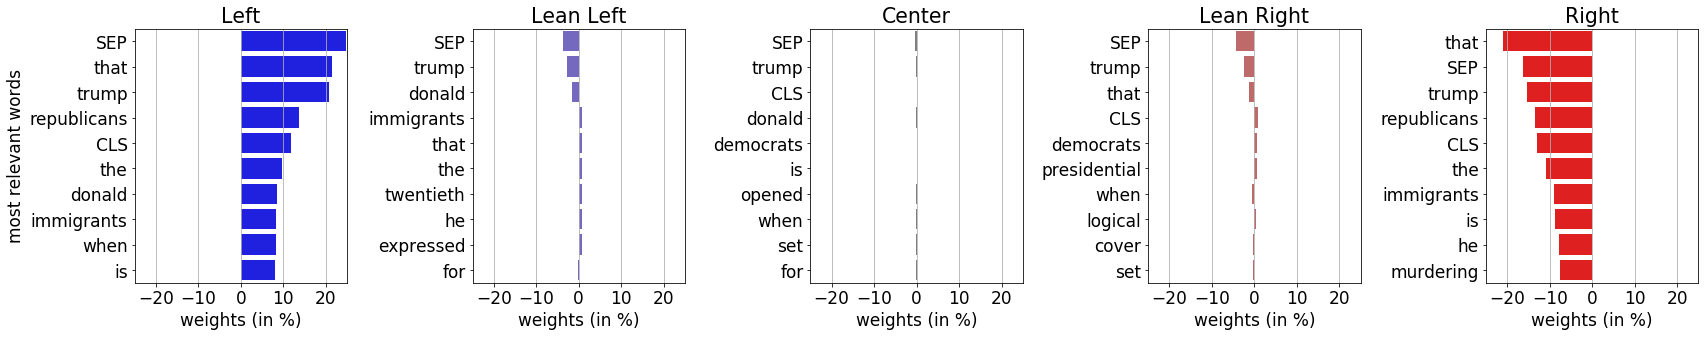

In [89]:
### Plot LIME results
general_font_size = 'medium'
plt.rcParams.update({'font.size': 17})
lime_df_columns = list(lime_df.columns)

fig, axes = plt.subplots(1,num_plots, figsize=[24,5])
# selecting min/max probability values from dataframe
lime_max = 25# 25 # 15
#int(np.ceil(np.max(np.array(lime_df.iloc[:,[i for i in range(len(lime_df_columns)) if i%2==1]]))))
lime_min = -25 # -25 #-15
#int(np.floor(np.min(np.array(lime_df.iloc[:,[i for i in range(len(lime_df_columns)) if i%2==1]]))))

#handles =  [plt.Rectangle((0,0),1,1, color=palette[label]) for label in palette.keys()]
#legend_labels = palette.keys()
#axes[3].legend(handles, legend_labels, ncol=5, bbox_to_anchor=(1, 1.2)) # loc='upper left', 

#sns.barplot(lime_df_columns[i*2+1], lime_df_columns[i*2], data=lime_df, color=palette[predicted_labels[i]], ax=axes[i])

for i in range(num_plots):
    sns.barplot(list(lime_df.iloc[:,i*2+1]), list(lime_df.iloc[:,i*2]), color=palette[predicted_labels[i]], ax=axes[i])
    axes[i].set_xlim([lime_min,lime_max])
    axes[i].set_xticks([-20,-10,0,10,20]) # [-15,-10,-5,0,5,10,15] # [-20,-10,0,10,20] 
    axes[i].grid(True, axis='x')
    axes[i].set_title(true_labels[i])
    axes[i].set_xlabel('weights (in %)')

axes[0].set_ylabel('most relevant words')

fig.tight_layout()

In [90]:
lime_example_name = 'politicus_left_right_example2'

In [83]:
fig.savefig(f'/home/tobias/Documents/Studium/Master_thesis/Latex_Vorlage_Final/images/lime_{lime_example_name}_plot.png')


In [95]:
html_lime = exp.as_html(predict_proba=False, text=True, opacity=False)

with open(f"/home/tobias/Documents/Studium/Master_thesis/programming/lime_examples/lime_{lime_example_name}.html", "w") as file:
    file.write(html_lime)

### Creating HTML file

In [93]:
html_lime = exp.as_html(predict_proba=False, text=True, opacity=False)

with open(f"lime_html_files/lime_{lime_example_name}.html", "w") as file:
    file.write(html_lime)

FileNotFoundError: [Errno 2] No such file or directory: 'lime_html_files/lime_politicus_left_right_example2.html'

### Save LIME explanation object

In [24]:
with open(f'lime_html_files/lime_{lime_example_name}_explanation', 'wb') as f:
    dill.dump(exp, f)

In [22]:
with open(f'lime_html_files/lime_{lime_example_name}explanation', 'rb') as f:
    exp = dill.load(f)

In [86]:
with open(f'/home/tobias/Documents/Studium/Master_thesis/programming/lime_examples/lime_politicus_usa_left_right_example_explanation', 'rb') as f:
    exp = dill.load(f)